In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import os
import numpy as np

import matplotlib as mpl

mpl.rcParams.update({"figure.facecolor": "white"})

In [2]:
use_sim_data = False
use_rmse = False

In [5]:
load_dir = r'C:\Users\jason\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\evaluation_loss\selected_keep\termination_relstep_1e-8_nshots_7.5e4'
df_dtime = pd.read_csv(load_dir + r'/eval_loss_dtimeTrue_OD1.5E+00-3.4E+00_order7-21_shots7.50E+04.csv')
df_pois = pd.read_csv(load_dir + r'/eval_loss_dtimeFalse_OD1.5E+00-3.4E+00_order7-21_shots7.50E+04.csv')

eval_loss_dtime = df_dtime['Evaluation Loss'].dropna()
eval_loss_pois = df_pois['Evaluation Loss'].dropna()
percent_active = df_dtime['Average %-age where Detector was Active'].dropna()
optimal_C = df_dtime['Optimal Scaling Factor'].dropna()
if use_sim_data:
    rho = df_dtime['Rho']
else:
    OD = df_dtime['OD'][:-1]
    transmit_factor = 10**(-OD)
    eval_loss_dtime = eval_loss_dtime[:-1]
    eval_loss_pois = eval_loss_pois[:-1]
    percent_active = percent_active[:-1]

# OD_C = df_dtime['Hypothetical Scaling Factor'][:-1]

# Plot Evaluation Loss vs OD

In [6]:
# if use_sim_data:
#     OD = OD[3:]
#     target_amp_dtime = target_amp_dtime[3:]
#     target_amp_pois = target_amp_pois[3:]
#     eval_loss_dtime = eval_loss_dtime[3:]
#     eval_loss_pois = eval_loss_pois[3:]
#     percent_active = percent_active[3:]

In [7]:
# rm_idx = np.where(rho==5e10)[0][0]
# rho.pop(rm_idx)
# eval_loss_dtime.pop(rm_idx)
# eval_loss_pois.pop(rm_idx)

In [8]:
# fig = plt.figure(dpi=400)
# ax = fig.add_subplot(111)  

# if use_sim_data:
#     ax.plot(rho, eval_loss_dtime, 's', color='blue', markeredgecolor='black', label='Deadtime model')
#     ax.plot(rho, eval_loss_pois, '^', color='orange', markeredgecolor='black', label='Poisson model')
#     ax.set_xlabel('Arrival rate [Hz]')
# else:
#     ax.plot(transmit_factor, eval_loss_dtime, 's', color='blue', markeredgecolor='black', label='Deadtime model')
#     ax.plot(transmit_factor, eval_loss_pois, '^', color='orange', markeredgecolor='black', label='Poisson model')
#     ax.set_xlabel('Optical Transmission')
# ax.set_ylabel('Evaluation Loss')
# plt.legend()
# plt.xscale('log')

# save_dir = r'C:/Users/Grant/Downloads'
# save_plt_file = r'/eval_loss_comparison.png'
# fig.savefig(save_dir + save_plt_file)
# plt.show()

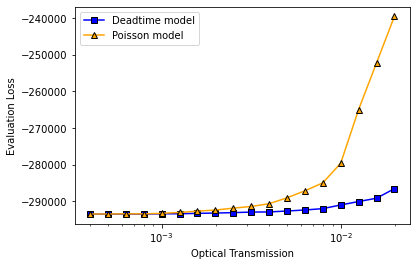

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
if use_sim_data:
    if use_rmse:
        ax.plot(target_amp_dtime, RMSE_dtime, 's', color='cyan', markeredgecolor='black', label='Deadtime model')
        ax.plot(target_amp_pois, RMSE_pois, '^', color='brown', markeredgecolor='black', label='Poisson model')
        ax.set_ylabel('Relative RMSE') 
        plt.legend()
    else:
        ax.plot(target_amp_dtime, eval_loss_dtime, 's', color='blue', markeredgecolor='black', label='Deadtime model')
        ax.plot(target_amp_pois, eval_loss_pois, '^', color='orange', markeredgecolor='black', label='Poisson model')
        ax.set_ylabel('Evaluation Loss') 
        plt.legend()
    ax.set_xlabel('Peak Arrival Rate')    
else:
    transmit_factor = 10**(-OD)
    atten_factor = 1-transmit_factor
    
    skip_num = 2
    ax.plot(transmit_factor[skip_num:], eval_loss_dtime[skip_num:], 's-', color='blue', markeredgecolor='black', label='Deadtime model')
    ax.plot(transmit_factor[skip_num:], eval_loss_pois[skip_num:], '^-', color='orange', markeredgecolor='black', label='Poisson model')
    ax.set_xlabel('Optical Transmission')
    ax.set_ylabel('Evaluation Loss')
    plt.legend()
    
plt.xscale('log')


save_dir = r'C:/Users/jason/Downloads'
save_plt_file = r'/eval_loss_comparison.png'
fig.savefig(save_dir + save_plt_file)
plt.show()

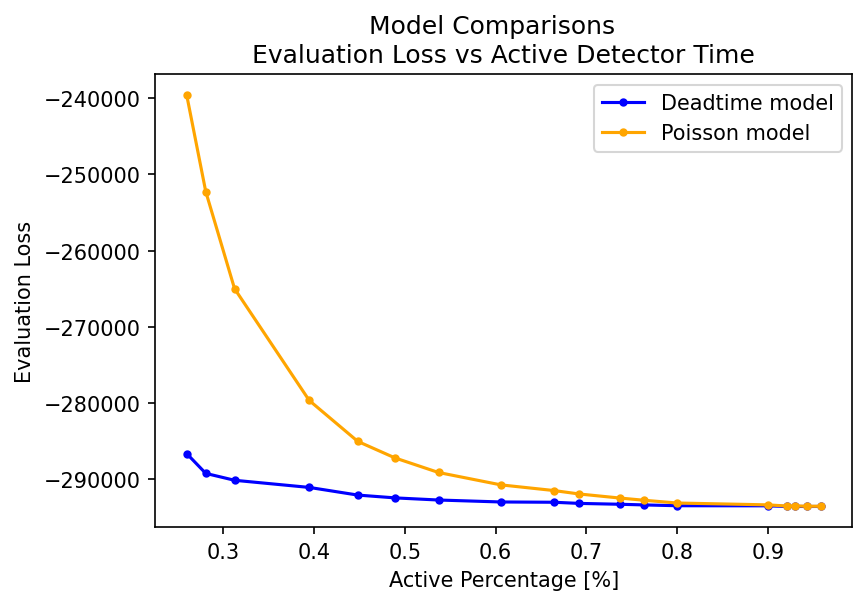

In [10]:
# Plot Eval Loss vs Average Active-Detector Percentage

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.plot(percent_active[skip_num:], eval_loss_dtime[skip_num:], '.-', color='blue', label='Deadtime model')
ax.plot(percent_active[skip_num:], eval_loss_pois[skip_num:], '.-', color='orange', label='Poisson model')
ax.set_xlabel('Active Percentage [%]')
ax.set_ylabel('Evaluation Loss')
plt.suptitle('Model Comparisons')
plt.title('Evaluation Loss vs Active Detector Time')
plt.legend()
plt.show()

# Exploring shot scarcity dimension

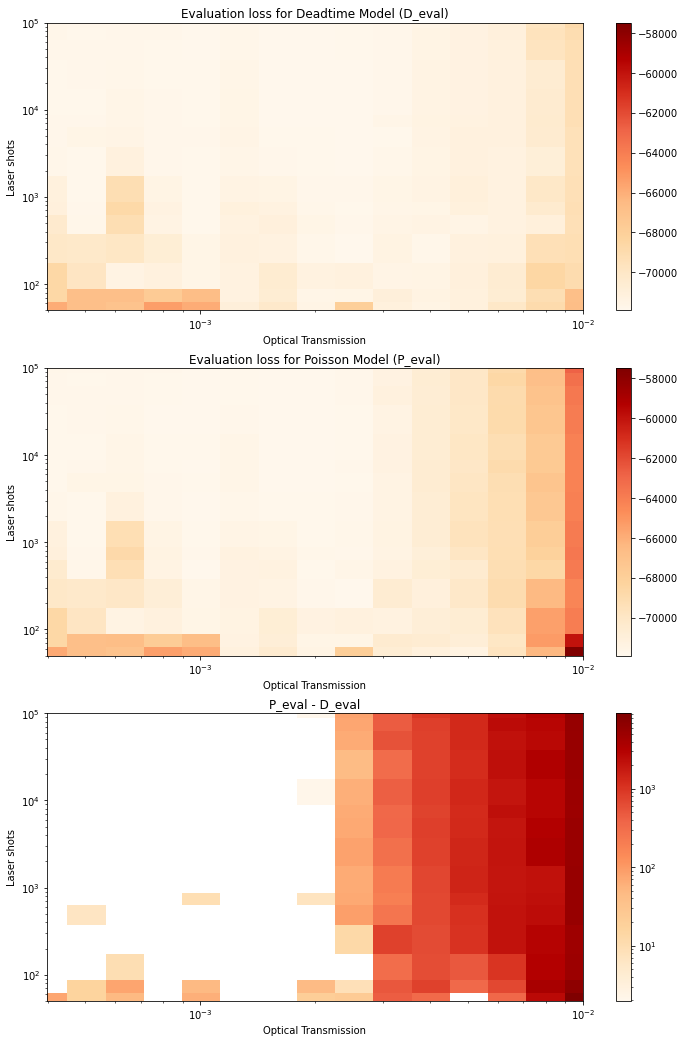

In [17]:
from matplotlib.colors import LogNorm

load_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\evaluation_loss\heatmap_iter\Deadtime'
eval_loss_dtime_dead = []
num_shot_dead = []
for file in os.listdir(load_dir):
    if file.endswith('.csv'):
        df_dtime = pd.read_csv(load_dir + r'/' + file)
        num_shot = float(file[-12:-4])
        OD = df_dtime['OD'][:-5]
        eval_loss_dtime = df_dtime['Evaluation Loss'].dropna()[4:]
        
        num_shot_dead.append(num_shot)
        eval_loss_dtime_dead.append(-1*eval_loss_dtime)
        
load_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\evaluation_loss\heatmap_iter\Poisson'
eval_loss_dtime_pois = []
num_shot_pois = []
for file in os.listdir(load_dir):
    if file.endswith('.csv'):
        df_dtime = pd.read_csv(load_dir + r'/' + file)
        num_shot = float(file[-12:-4])
        OD = df_dtime['OD'][:-5]
        eval_loss_dtime = df_dtime['Evaluation Loss'].dropna()[4:]
        
        num_shot_pois.append(num_shot)
        eval_loss_dtime_pois.append(-1*eval_loss_dtime)
        
reorder_dead = np.argsort(num_shot_dead).astype(int)
reorder_pois = np.argsort(num_shot_pois).astype(int)

num_shot_dead = np.array(num_shot_dead)[reorder_dead]
num_shot_pois = np.array(num_shot_pois)[reorder_pois]
eval_loss_dtime_dead = np.array(eval_loss_dtime_dead)[reorder_dead]
eval_loss_dtime_pois = np.array(eval_loss_dtime_pois)[reorder_pois]

transmit_factor = 10**(-OD)

fig = plt.figure(figsize=(12,18))
ax1 = fig.add_subplot(311)
c = ax1.pcolormesh(transmit_factor, num_shot_dead, -1*eval_loss_dtime_dead, cmap='OrRd', vmin=-1*eval_loss_dtime_pois.max(), vmax=-1*eval_loss_dtime_pois.min())
ax1.axis([transmit_factor.min(), transmit_factor.max(), min(num_shot_dead), max(num_shot_dead)])
ax1.set_ylabel('Laser shots')
ax1.set_xlabel('Optical Transmission')
ax1.set_title('Evaluation loss for Deadtime Model (D_eval)')
ax1.set_yscale('log')
ax1.set_xscale('log')
fig.colorbar(c, ax=ax1)

ax2 = fig.add_subplot(312)
c = ax2.pcolormesh(transmit_factor, num_shot_pois, -1*eval_loss_dtime_pois, cmap='OrRd', vmin=-1*eval_loss_dtime_pois.max(), vmax=-1*eval_loss_dtime_pois.min())
ax2.axis([transmit_factor.min(), transmit_factor.max(), min(num_shot_pois), max(num_shot_pois)])
ax2.set_ylabel('Laser shots')
ax2.set_xlabel('Optical Transmission')
ax2.set_title('Evaluation loss for Poisson Model (P_eval)')
ax2.set_yscale('log')
ax2.set_xscale('log')
fig.colorbar(c, ax=ax2)

ax3 = fig.add_subplot(313)
c = ax3.pcolormesh(transmit_factor, num_shot_dead, (eval_loss_dtime_dead-eval_loss_dtime_pois), norm=LogNorm(), cmap='OrRd')
ax3.axis([transmit_factor.min(), transmit_factor.max(), min(num_shot_pois), max(num_shot_pois)])
ax3.set_ylabel('Laser shots')
ax3.set_xlabel('Optical Transmission')
ax3.set_title("P_eval - D_eval")
ax3.set_yscale('log')
ax3.set_xscale('log')
fig.colorbar(c, ax=ax3)

save_dir = r'C:/Users/Grant/Downloads'
save_plt_file = r'/pois_vs_dtime_eval_loss.png'
fig.savefig(save_dir + save_plt_file)
plt.show()


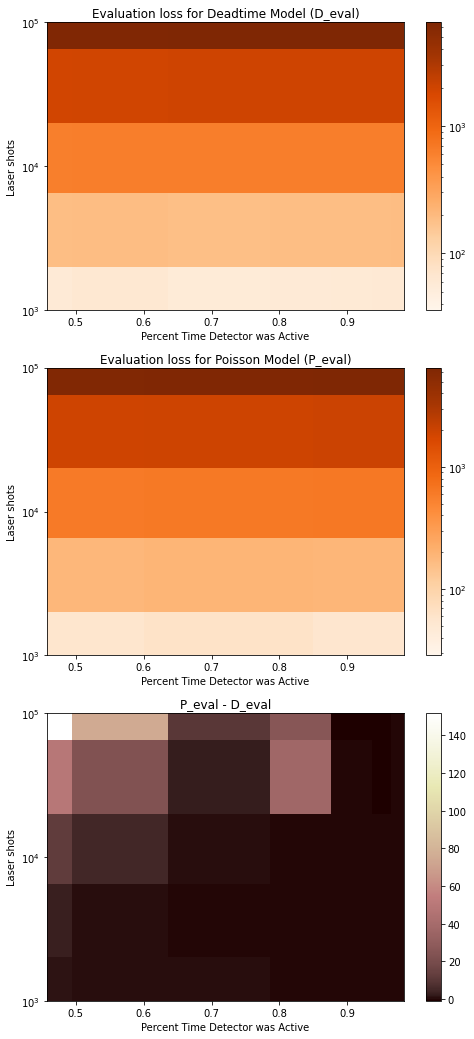

In [21]:
from matplotlib.colors import LogNorm

load_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\Deadtime_Experiments\Figures\evaluation_loss\iter_num_shots_test2'
files = []
eval_loss_dtime_full = []
num_shot_full = []
for file in os.listdir(load_dir):
    if file.endswith('.csv'):
        files.append(r'/'+file)
        df_dtime = pd.read_csv(load_dir + r'/'+file)
        num_shot = float(file[-9:-4])
        OD = df_dtime['OD'][:-1]
        eval_loss_dtime = df_dtime['Evaluation Loss'].dropna()
        percent_active = df_dtime['Average %-age where Detector was Active'].dropna()
        optimal_C = df_dtime['Optimal Scaling Factor'].dropna()
        OD_C = df_dtime['Hypothetical Scaling Factor'][:-1]
        
        num_shot_full.append(num_shot)
        eval_loss_dtime_full.append(eval_loss_dtime)
        
max_lsr_num_lst = np.floor(np.logspace(3, 7, 16)).astype(int)[:-4]

reorder = np.argsort(num_shot_full).astype(int)
num_shot_full = np.array(num_shot_full)[reorder]
eval_loss_dtime_full = np.array(eval_loss_dtime_full)[reorder]
eval_loss_dtime_dead = -1*eval_loss_dtime_full[1::2]
num_shot_dead = num_shot_full[1::2]
eval_loss_dtime_pois = -1*eval_loss_dtime_full[0::2]
num_shot_pois = num_shot_full[0::2]

# print(eval_loss_dtime_full)

fig = plt.figure(figsize=(8,18))
ax1 = fig.add_subplot(311)
c = ax1.pcolormesh(percent_active[2:], num_shot_dead, eval_loss_dtime_dead[:, 2:], norm=LogNorm(eval_loss_dtime_dead.min(), eval_loss_dtime_dead.max()), cmap='Oranges')
ax1.axis([percent_active[2:].min(), percent_active.max(), min(num_shot_dead), max(num_shot_dead)])
ax1.set_ylabel('Laser shots')
ax1.set_xlabel('Percent Time Detector was Active')
ax1.set_title('Evaluation loss for Deadtime Model (D_eval)')
ax1.set_yscale('symlog')
fig.colorbar(c, ax=ax1)

ax2 = fig.add_subplot(312)
c = ax2.pcolormesh(OD[2:], num_shot_pois, eval_loss_dtime_pois[:, 2:], norm=LogNorm(eval_loss_dtime_pois.min(), eval_loss_dtime_pois.max()), cmap='Oranges')
ax2.axis([percent_active[2:].min(), percent_active.max(), min(num_shot_pois), max(num_shot_pois)])
ax2.set_ylabel('Laser shots')
ax2.set_xlabel('Percent Time Detector was Active')
ax2.set_title('Evaluation loss for Poisson Model (P_eval)')
ax2.set_yscale('symlog')
fig.colorbar(c, ax=ax2)

ax3 = fig.add_subplot(313)
c = ax3.pcolormesh(percent_active[2:], num_shot_dead, (eval_loss_dtime_dead-eval_loss_dtime_pois)[:, 2:], cmap='pink')
ax3.axis([percent_active[2:].min(), percent_active.max(), min(num_shot_dead), max(num_shot_dead)])
ax3.set_ylabel('Laser shots')
ax3.set_xlabel('Percent Time Detector was Active')
ax3.set_title("P_eval - D_eval")
ax3.set_yscale('symlog')
fig.colorbar(c, ax=ax3)

# ax2 = fig.add_subplot(212, projection='3d')
# xv_dead, yv_dead = np.meshgrid(OD, np.log10(num_shot_dead), indexing='ij')
# xv_pois, yv_pois = np.meshgrid(OD, np.log10(num_shot_pois), indexing='ij')
# ax2.scatter(xv_dead[2:, :], yv_dead[2:, :], eval_loss_dtime_dead.T[2:, :], c='green', label='Deadtime model')
# ax2.scatter(xv_pois[2:, :], yv_pois[2:, :], eval_loss_dtime_pois.T[2:, :], c='blue', label='Poisson model')
# ax2.set_xlabel('OD')
# ax2.set_ylabel('log10(Laser shots)')
# ax2.set_zlabel('Evaluation Loss')
# ax2.set_yscale('symlog')
# # ax2.set_xlim([OD.min(), OD.max()])
# plt.legend()

plt.show()


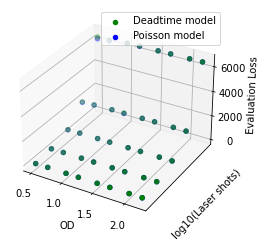

In [22]:
fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
xv_dead, yv_dead = np.meshgrid(OD, np.log10(num_shot_dead), indexing='ij')
xv_pois, yv_pois = np.meshgrid(OD, np.log10(num_shot_pois), indexing='ij')
ax2.scatter(xv_dead[2:, :], yv_dead[2:, :], eval_loss_dtime_dead.T[2:, :], c='green', label='Deadtime model')
ax2.scatter(xv_pois[2:, :], yv_pois[2:, :], eval_loss_dtime_pois.T[2:, :], c='blue', label='Poisson model')
ax2.set_xlabel('OD')
ax2.set_ylabel('log10(Laser shots)')
ax2.set_zlabel('Evaluation Loss')
ax2.set_yscale('symlog')
# ax2.set_xlim([OD.min(), OD.max()])
plt.legend()

plt.show()

# Graveyard

In [ ]:
# Plot scaling factors vs Average Active-Detector Percentage

# fig = plt.figure(figsize=(12,8))
# ax1 = fig.add_subplot(121)
# ax1.plot(percent_active, optimal_C, 'b.', label='Optimal Scaling Factor')
# ax1.plot(percent_active, OD_C, 'm.', label='Scaling Factor based on OD')
# ax1.set_xlabel('Active Percentage')
# ax1.set_ylabel('Scaling Factor')
# ax2 = fig.add_subplot(122)
# ax2.plot(percent_active, OD_C/optimal_C, 'b.', label='Optimal Scaling Factor')
# ax2.set_xlabel('Active Percentage')
# ax2.set_ylabel('Ratio of Scaling Factors (Hypothetical/Optimal)')
# plt.suptitle('Scaling Factor Comparisons')
# ax1.legend()
# plt.show()